# Load Packages

In [4]:
# Main modules 
import torch
from torch import Generator
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.transforms.functional import to_pil_image
import pandas as pd
import matplotlib.pyplot as plt

# Custom modules
from frogfunctions import Model 
from frogfunctions import setup_seed, train_loop, test_loop, train_model, plot_probabilities

In [5]:
# Dataframe output format
pd.set_option('display.float_format', lambda x: '%.6f' % x)

# Set device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Set random seed for reproduction

In [6]:
SEED = 42
setup_seed(SEED)

# Import data

In [ ]:
data_dir = "../data/"

In [ ]:
# Download and load the training data
dataset_all = ImageFolder(data_dir, transform=torchvision.transforms.ToTensor())

# Print number in full data set
size_all = len(dataset_all)
print(f'Before splitting the full dataset into train and test: len(dataset_all) = {size_all}')

# Split into Test, Validation, and Training
size_test = int(size_all * 0.10)
size_val = int(size_all * 0.10)
size_train = size_all - size_test - size_val
dataset_test, dataset_val, dataset_train = random_split(dataset_all, [size_test, size_val, size_train], 
                                                        generator=Generator().manual_seed(SEED))

print(f'After splitting the full dataset into test, validation, and training: \n \
      len(dataset_test) = {len(dataset_test)} \n \
      len(dataset_val) = {len(dataset_val)} \n \
      len(dataset_train) = {len(dataset_train)}')

In [ ]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['02', '03', '04', '05', '08', '10', 'Background']

# Rows and columns are set to fit one training batch (16)
n_rows = 4
n_cols = 4
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, target = dataset_train[index]
        plt.imshow(to_pil_image(image))
        plt.axis('off')
        plt.title(class_names[target], fontsize=12)
plt.subplots_adjust(wspace=.05, hspace=.05)
plt.show()

# Prepare data

In [7]:
# Define batch size
batch_size = 16

In [ ]:
# Load data into DataLoader
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

dataloaders = {'train':train_dataloader, 'val':val_dataloader}
dataset_sizes = {'train':len(dataset_train), 'val':len(dataset_val)}

# Define parameters for model

In [8]:
# Define number of classes
num_classes = 7

In [9]:
# Create model 
model = Model(num_classes=num_classes).to(device)

In [10]:
# Define hyperparameters
learning_rate = 0.002
weight_decay = 0.005
momentum=0.09

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Define optimizer 
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

# Train model

In [ ]:
# Set number of epochs 
epochs = 20

# Train
train_model(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs)

# Test model on test data set

In [ ]:
# Test accuracy
test_loop(test_dataloader, model, loss_fn, 'test')

In [ ]:
# Class prediction probabilities
predictions = test_loop(test_dataloader, model, loss_fn, 'prob')
predictions.head()

In [ ]:
# Plot probabilities
plot_probabilities(predictions, title='Classification of test data set', xlabel='Image number')

# Save model

In [ ]:
PATH = '../saved_models/model'
torch.save(model.state_dict(), PATH)

----

# Load model

In [14]:
PATH = '../saved_models/model'
model = Model(num_classes=7).to(device)
model.load_state_dict(torch.load(PATH))
model.eval();

# Test model on long audio files (Ex. 1)

In [15]:
test1_dir = "../test_data/city/"

In [16]:
# Download and load the training data
test1 = ImageFolder(test1_dir, transform=torchvision.transforms.ToTensor())

# Load data into DataLoader
test1_dataloader = DataLoader(test1, batch_size=batch_size, shuffle=False)

# Class prediction probabilities
test1_predictions = test_loop(test1_dataloader, model, loss_fn, 'prob')
test1_predictions.head()

,Upper Amazon tree frog,Demerara Falls tree frog,Chirping Robber frog,Vanzolini's Amazon frog,South American common toad,Peters' dwarf frog,Background
0,0.045669,0.001534,0.100860,0.018296,0.024114,0.019140,0.790387
1,0.025649,0.001212,0.035781,0.007832,0.049478,0.022688,0.857360
2,0.022792,0.001693,0.052670,0.007819,0.069288,0.031772,0.813967
3,0.086613,0.002122,0.107237,0.049517,0.013632,0.018372,0.722507
4,0.393348,0.000497,0.004037,0.390743,0.000181,0.001390,0.209804


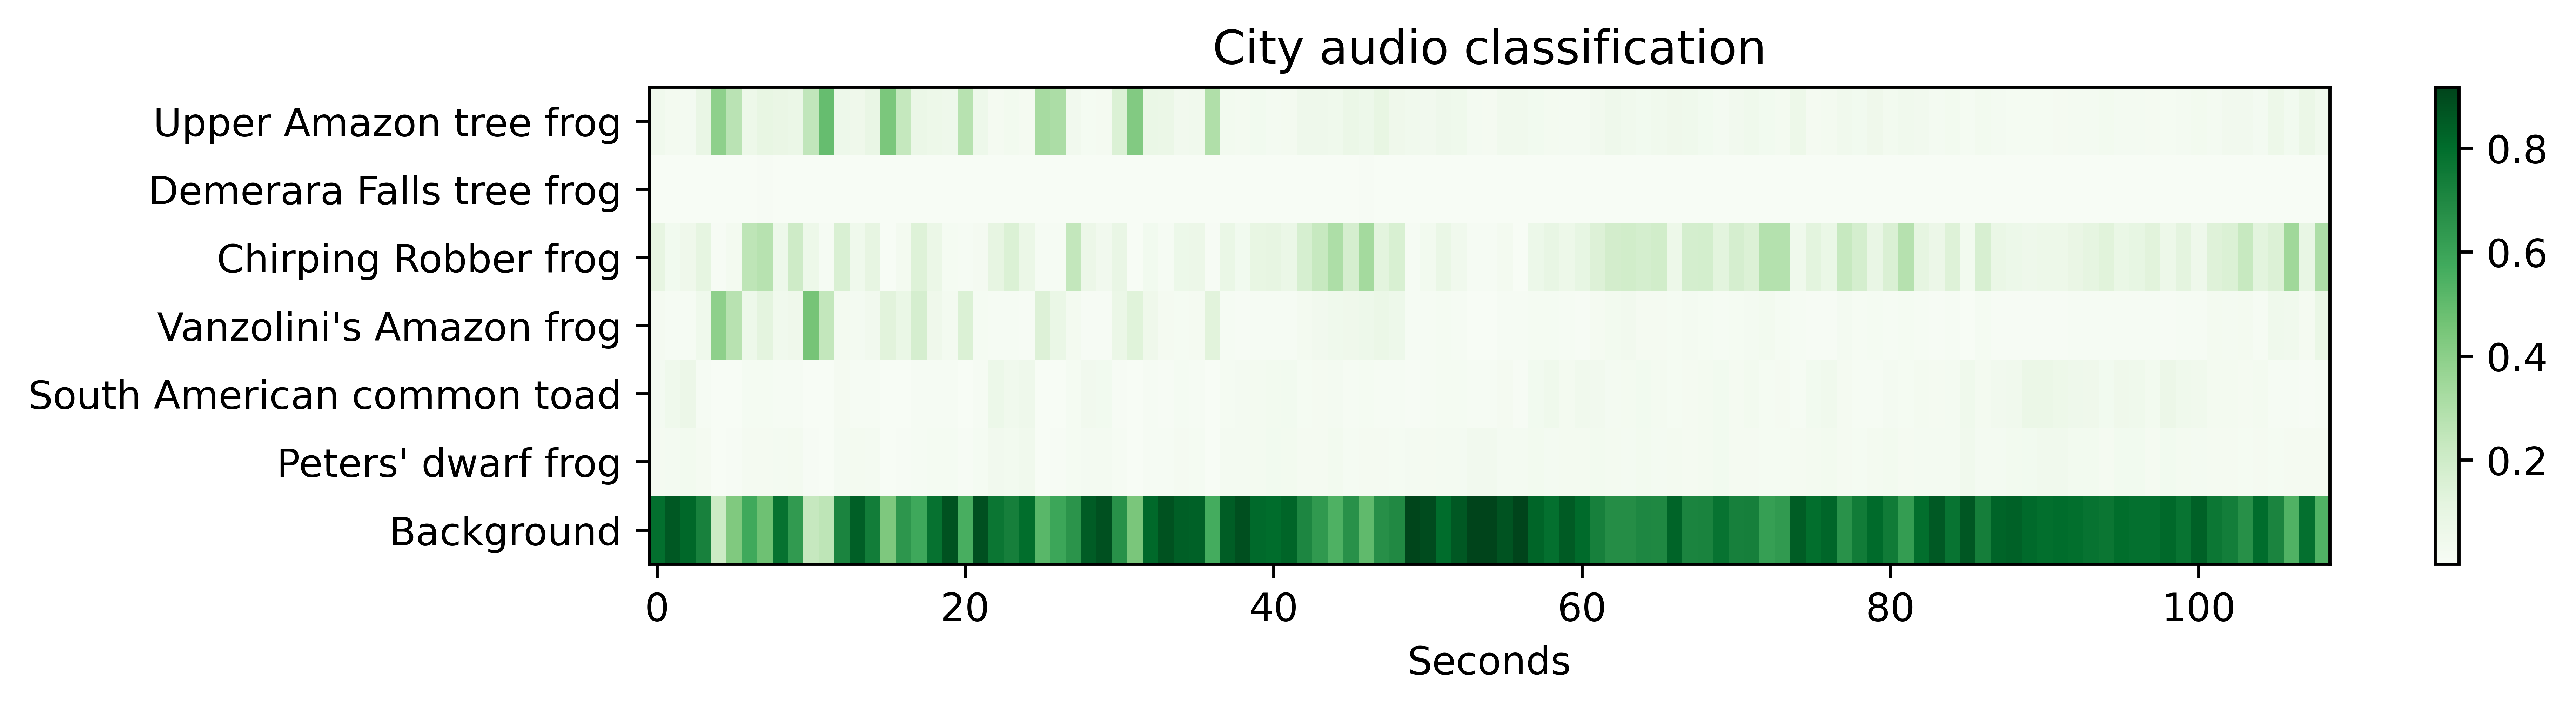

In [17]:
# Plot probabilities
plot_probabilities(test1_predictions, title='City audio classification', xlabel='Seconds')

# Test model on long audio files (Ex. 2)

In [18]:
test2_dir = "../test_data/long/"

In [19]:
# Download and load the training data
test2 = ImageFolder(test2_dir, transform=torchvision.transforms.ToTensor())

# Load data into DataLoader
test2_dataloader = DataLoader(test2, batch_size=batch_size, shuffle=False)

# Class prediction probabilities
test2_predictions = test_loop(test2_dataloader, model, loss_fn, 'prob')
test2_predictions.head()

,Upper Amazon tree frog,Demerara Falls tree frog,Chirping Robber frog,Vanzolini's Amazon frog,South American common toad,Peters' dwarf frog,Background
0,0.632310,0.002253,0.004768,0.143442,0.001136,0.009891,0.206201
1,0.572204,0.001367,0.002998,0.127161,0.000855,0.012562,0.282853
2,0.831254,0.011013,0.058407,0.067414,0.002164,0.007221,0.022525
3,0.831763,0.006776,0.033998,0.072120,0.001932,0.007209,0.046201
4,0.857197,0.006930,0.045671,0.041796,0.001843,0.006655,0.039907


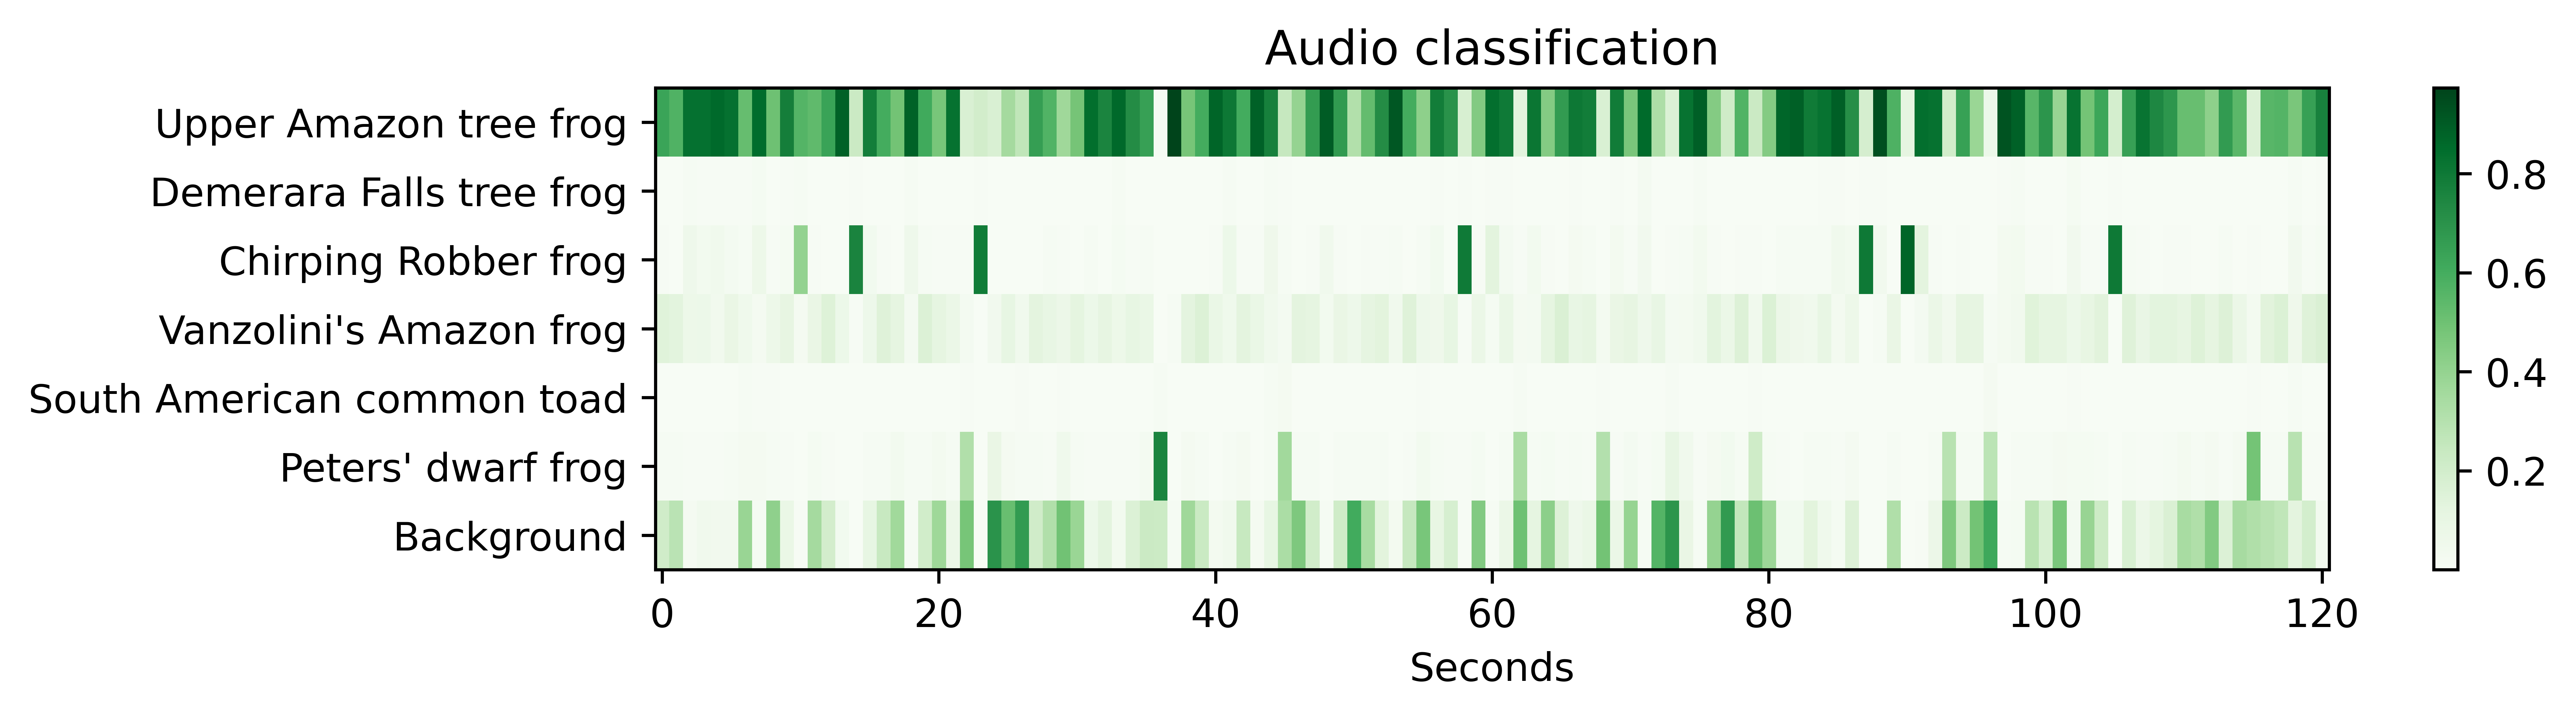

In [21]:
# Plot probabilities
plot_probabilities(test2_predictions, title='Audio classification', xlabel='Seconds')